In [8]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import math
from PIL import Image, ImageFilter
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import mean_squared_error
from skimage import img_as_float
from skimage.filters import threshold_otsu

In [9]:
#imagen original que incluye un ruido intrinseco
imagen = cv2.imread('42original.png', cv2.IMREAD_GRAYSCALE)

In [10]:
# Convert to normalized floating point
imagen = cv2.normalize(imagen.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX) 

In [17]:
#funcion sigma

def SigmaFondo(imagen):

    sqImagen = imagen**2
    umbral = threshold_otsu(sqImagen) 
    fondo = (sqImagen < umbral)*sqImagen 
    sigma = np.std(fondo) 
    return sigma

In [54]:
#funcion kernel 
def make_kernel(f):              
 
    kernel=np.zeros((2*f+1,2*f+1))  
    for d in range(1,f+1):    
        value= 1 / (2*d+1)**2  
        for i in range(-d,d+1):
            for j in range(-d,d+1):
                kernel[f+1-i-1,f+1-j-1]= kernel[f+1-i-1,f+1-j-1] + value 
     
    kernel = kernel / f
    return kernel

In [71]:
#filtro NLM 

def FiltroNLM(imagen,sigma):
    
#     t: radio ventana de b�squeda
#     f: radio ventana de similitud
#     h: grado de filtrado
#     LA IAMGEN QUE SE INGRESA DEBE ESTAR EN GRAYSCALE Y NORMALIZADA CON:
            #cv2.normalize(imagen.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX) 
#     Implementation of the Non local filter proposed for A. Buades, B. Coll and J.M. Morel in
#     "A non-local algorithm for image denoising"

    t = 7    #/7
    f = 9   #/5
    h = 1.5*sigma
    
    #tamaño de la imagen
    [m,n] = imagen.shape 
    
    #memoria para el output
    NLM = np.zeros((m,n))
    UNLM = np.zeros((m,n))
    
    #Replicate the boundaries of the input image
    input2 = np.pad(imagen, (f, f), 'symmetric') #para abarcar los pixeles de los bordes
    
    # Used kernel
    kernel = make_kernel(f)             
    kernel = kernel / sum(sum(kernel))  
    
    
    h=h*h
    
    for i in range(1,m+1):      #recorre todas las filas                      
        for j in range(1,n+1):      #recorre todas las columnas
            
            i1 = i+ f
            j1 = j+ f
                
            W1= input2[i1-f-1:i1+f , j1-f-1:j1+f]  

            wmax=0 
            average=0
            sweight=0
         
            rmin = max(i1-t,f+1)
            rmax = min(i1+t,m+f)
            smin = max(j1-t,f+1)
            smax = min(j1+t,n+f)
            
            for r in range(rmin,rmax+1,1):                          
                for s in range(smin,smax+1,1):                      
                                               
                    if (r==i1 and s==j1):
                        continue

                    W2= input2[r-f-1:r+f , s-f-1:s+f]                
                    d = sum(sum(kernel*(W1-W2)*(W1-W2)))
                    w = math.exp(-d/h)   
                    
                    if w>wmax:                
                        wmax=w                   

                    sweight = sweight + w
                    average = average + w*input2[r,s]
                    

            average = average + wmax*input2[i1,j1]
            sweight = sweight + wmax
            
            if sweight > 0:
                NLM[i-1,j-1] = average / sweight               
            else:
                NLM[i,j] = imagen[i,j]
                
    UNLM = np.sqrt(NLM**2 - 2*sigma*sigma).real                    
    Residuo = imagen - UNLM
    
    return NLM,UNLM,Residuo


In [72]:
sigma = SigmaFondo(imagen)

In [73]:
[NLM,imagen_1,Residuo1] = FiltroNLM(imagen,sigma)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in sqrt


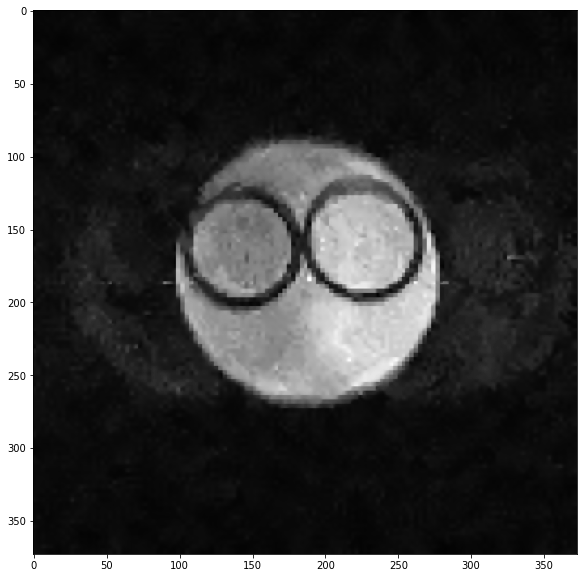

In [66]:
plt.figure(figsize=(10,10))
plt.imshow(NLM, cmap='gray')
plt.show()

In [67]:
#metricas
psnr_1 = psnr(imagen,NLM)
ssim_1 = ssim(imagen, NLM)
mse_none = mean_squared_error(imagen, NLM)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  This is separate from the ipykernel package so we can avoid doing imports until


In [68]:
psnr_1

26.203398329606312

In [69]:
ssim_1

0.7928915191330081

In [70]:
mse_none

0.0023969565801194945